# Large Dataset Model Building On All Joints

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'2.0.0'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('jackson_megadata_10_23.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [5]:
df.head()

,Unnamed: 0,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,0,1.571862e+09,0.006472,1.571862e+09,56.0,152.0,318.0,58.0,30.0,26.0,37.0,168.0,27.481928,0.635315,44.404579,3.819370,-10.501190,57.583588,-39.021576,-14.662689,37.134148,-69.938087,-15.536011,26.992786,-90.684303,-16.765839,18.792263,-31.480103,3.195557,-11.996174,-48.617424,12.979187,-47.950493,-56.789734,2.440277,-66.780174,-59.230820,-12.140320,-73.670944,-12.269012,5.741394,-20.408253,-26.628906,19.429688,-61.925949,-36.830482,8.192657,-84.433563,-41.600212,-7.619537,-91.437363,9.305349,5.784424,-23.192884,-1.900085,17.207031,-62.730690,-11.677986,6.098206,-84.647568,-17.221012,-9.363892,-91.600197,29.291636,1.544373,-23.824600,22.835503,5.419800,-56.729340,17.429138,2.168213,-74.302849,11.652407,-4.481842,-88.201462
1,1,1.571862e+09,-0.017444,1.571862e+09,54.0,164.0,301.0,148.0,43.0,29.0,36.0,169.0,26.647976,-0.541893,44.900626,2.603665,-11.599823,57.431037,-39.666034,-14.301682,35.652349,-70.089661,-14.468178,24.132261,-90.578381,-15.055008,15.274604,-31.203072,3.832390,-12.509948,-47.597781,14.169205,-48.651957,-55.505336,3.798073,-67.685915,-57.910363,-10.747452,-74.662590,-11.808361,6.275238,-20.517360,-25.454881,20.207542,-62.191739,-35.418246,9.399536,-85.011818,-40.310819,-6.143776,-92.508541,9.811148,6.081985,-22.903098,-0.553401,17.576523,-62.645160,-9.981847,6.514847,-84.736057,-15.500547,-8.887718,-91.833954,29.747767,1.589165,-23.245819,24.140824,6.374512,-56.173798,19.047623,3.444153,-73.894844,13.431637,-3.077950,-87.919249
2,2,1.571862e+09,0.003166,1.571862e+09,50.0,161.0,401.0,184.0,49.0,32.0,37.0,162.0,25.490219,-3.977844,45.407623,0.888691,-15.207642,56.645126,-40.799980,-12.787781,33.687691,-70.586067,-9.926239,20.879833,-91.010010,-7.984314,12.033489,-30.784788,5.359344,-12.988110,-46.170105,17.185913,-49.120426,-53.684822,7.380035,-68.608513,-56.010406,-6.984161,-75.977188,-11.141672,7.823792,-20.362720,-23.704641,23.463989,-61.773483,-33.332466,13.942474,-85.301781,-38.390213,-0.982178,-93.875229,10.523100,7.254333,-22.239563,1.277081,20.302490,-61.781082,-7.774546,10.311188,-84.531990,-13.392775,-4.599304,-92.547852,30.355955,2.308136,-22.387161,26.408840,10.257629,-54.954762,21.679298,8.039429,-72.880737,16.065914,1.318481,-86.812164
3,3,1.571862e+09,0.010059,1.571862e+09,40.0,170.0,451.0,206.0,52.0,32.0,28.0,82.0,25.153648,-5.140533,45.478523,0.395868,-16.426270,56.309441,-41.075424,-11.990051,33.259583,-70.632256,-7.888000,20.259293,-91.043556,-4.950928,11.661678,-30.656673,5.864960,-13.072382,-45.760315,17.912903,-49.250374,-53.120193,8.142944,-68.815437,-55.381058,-6.207825,-76.230270,-10.946850,8.341492,-20.262655,-23.150558,24.345184,-61.641949,-32.622368,15.204285,-85.383560,-37.708450,0.511047,-94.331711,10.725384,7.651855,-22.008507,1.703369,20.909332,-61.532143,-7.254799,11.117615,-84.406494,-12.890709,-3.660126,-92.652481,30.522303,2.563080,-22.131792,27.211058,11.719635,-54.452309,22.549606,9.592224,-72.407104,16.8547

In [6]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)
df = df.drop(df.columns[0], axis=1)

In [7]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000,410705.000000
mean,69.830650,194.624456,327.642768,71.728214,44.296870,87.210112,73.443849,95.129351,13.433740,-9.918895,49.406393,-11.376644,-25.605264,51.338970,-44.872333,-24.645973,18.824727,-61.431829,-24.770864,-7.855166,-77.766978,-23.818628,-20.041394,-27.111190,4.681878,-20.149181,-31.168010,2.216711,-56.533035,-31.400229,-3.194320,-73.436094,-30.786220,-7.652179,-83.590116,-6.693581,10.463009,-21.165028,-6.515101,11.520539,-63.206372,-5.261173,7.249119,-84.549727,-3.946629,3.396960,-96.981908,14.726588,12.407608,-16.884533,16.900805,11.061808,-56.082492,18.437839,4.973580,-76.538139,19.668363,-0.382871,-88.293062,34.624458,9.507856,-12.152019,44.629017,11.456136,-40.051041,49.475038,9.713231,-53.828391,53.471617,7.140140,-64.891697
std,52.362277,117.678324,202.985681,44.448922,36.061338,141.084668,73.084319,68.073366,11.101877,9.608523,5.131227,12.637440,11.062260,5.787927,11.626375,7.278401,10.328375,15.079041,12.786336,15.241664,21.838932,17.859002,19.772263,4.206371,4.495053,6.532463,13.169467,20.142673,11.303510,17.535305,30.724830,20.110927,20.610897,36.878668,29.311201,4.934637,4.187734,2.722228,14.825448,20.637099,8.213241,19.314485,33.083783,18.344533,21.852345,39.955083,27.991373,4.647071,4.449165,4.145501,14.127276,19.079015,6.454849,19.054060,31.085150,15.175452,21.861600,38.290924,24.522839,4.250847,5.660208,7.977864,13.918032,17.930563,10.334027,19.450786,26.805241,12.623608,24.040729,34.119182,17.605140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18.788593,-47.219574,0.000000,-45.582393,-60.541901,0.000000,-64.980680,-66.381989,-11.942673,-85.509727,-81.291138,-44.110306,-107.789253,-91.676575,-66.343353,-35.445511,-20.730328,-32.883482,-71.428963,-58.541824,-73.250750,-92.259822,-77.042549,-96.800034,-107.166021,-91.046356,-113.517113,-22.855350,-12.155167,-25.658291,-56.705952,-56.844780,-73.379822,-75.681870,-79.146027,-101.507748,-89.119637,-95.912731,-120.184189,-7.060419,-11.240997,-26.

In [8]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [9]:
feature_ar.shape

(410705, 8)

In [10]:
label_ar.shape

(410705, 63)

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [11]:
seq_length = 32

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(410674, 32, 8)
(410674, 63)


### FC Architecture (Small)

In [12]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.5))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=2048, epochs=5, verbose=1, validation_split=0.2)

Train on 328539 samples, validate on 82135 samples
Epoch 1/5
328539/328539 [==============================] - 126s 384us/sample - loss: 1086.0460 - val_loss: 837.8746
Epoch 2/5
328539/328539 [==============================] - 123s 374us/sample - loss: 369.8105 - val_loss: 1024.4610
Epoch 3/5
328539/328539 [==============================] - 124s 378us/sample - loss: 336.6834 - val_loss: 4527.5117
Epoch 4/5
328539/328539 [==============================] - 130s 394us/sample - loss: 332.7974 - val_loss: 48775.4029
Epoch 5/5
328539/328539 [==============================] - 127s 387us/sample - loss: 311.2259 - val_loss: 10696.3956


In [13]:
model_fc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 64)            18688     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               4

### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

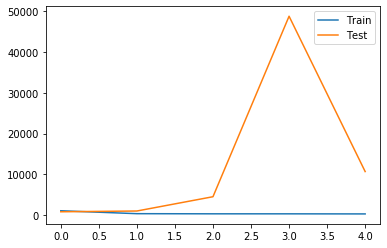

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

In [15]:
preds = model_fc.predict(features)

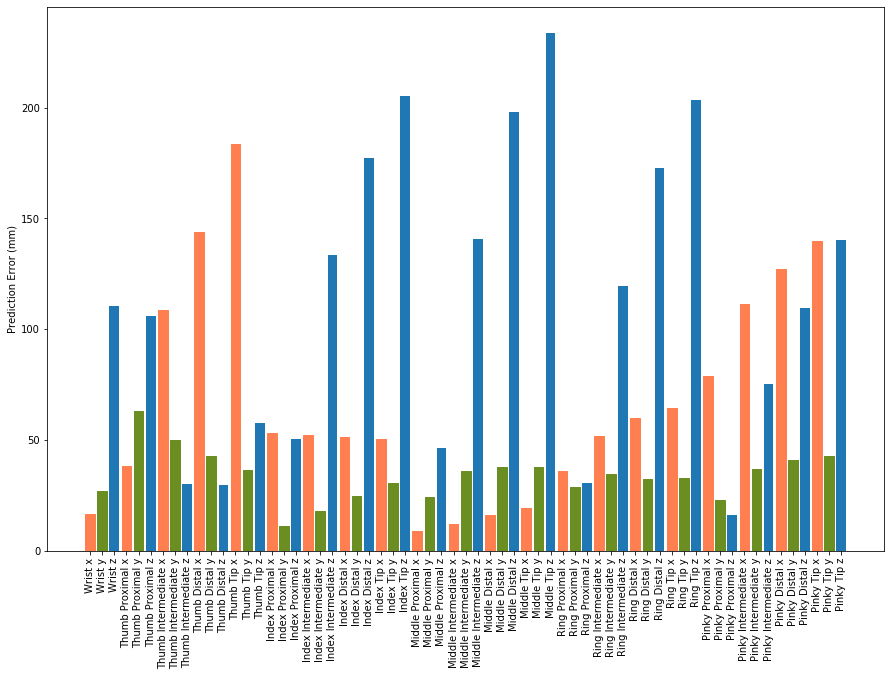

In [16]:
error = labels - preds
abs_error = np.absolute(error)
avg_error = np.mean(abs_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Large FC Model Architecture
Here a much larger model architecture is implemented to understand if this will improve results on the larger dataset. This dataset is approx 650MB, thus a larger model with proportionally higher parameters is expected to be required.

In [17]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(256, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(256, return_sequences=True))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(128))
model_fc.add(BatchNormalization())
model_fc.add(Dense(512, input_dim=128))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(512, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(256, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(63, input_dim=64))
    
model_fc.compile(optimizer='Adam', loss='mse')

In [18]:
model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32, 256)           271360    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 256)           525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 512)              

In [19]:
history = model_fc.fit(features, labels, batch_size=512, epochs=4, verbose=1, validation_split=0.2)

Train on 328539 samples, validate on 82135 samples
Epoch 1/4
328539/328539 [==============================] - 1013s 3ms/sample - loss: 290.4243 - val_loss: 665.9080
Epoch 2/4
328539/328539 [==============================] - 985s 3ms/sample - loss: 124.9392 - val_loss: 494.8746
Epoch 3/4
328539/328539 [==============================] - 1010s 3ms/sample - loss: 103.4529 - val_loss: 472.6404
Epoch 4/4
328539/328539 [==============================] - 976s 3ms/sample - loss: 93.0157 - val_loss: 506.4118


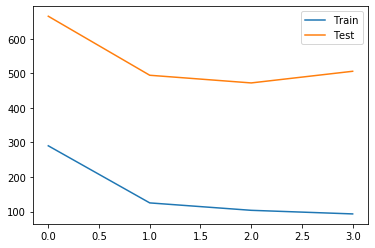

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

In [21]:
preds = model_fc.predict(features)

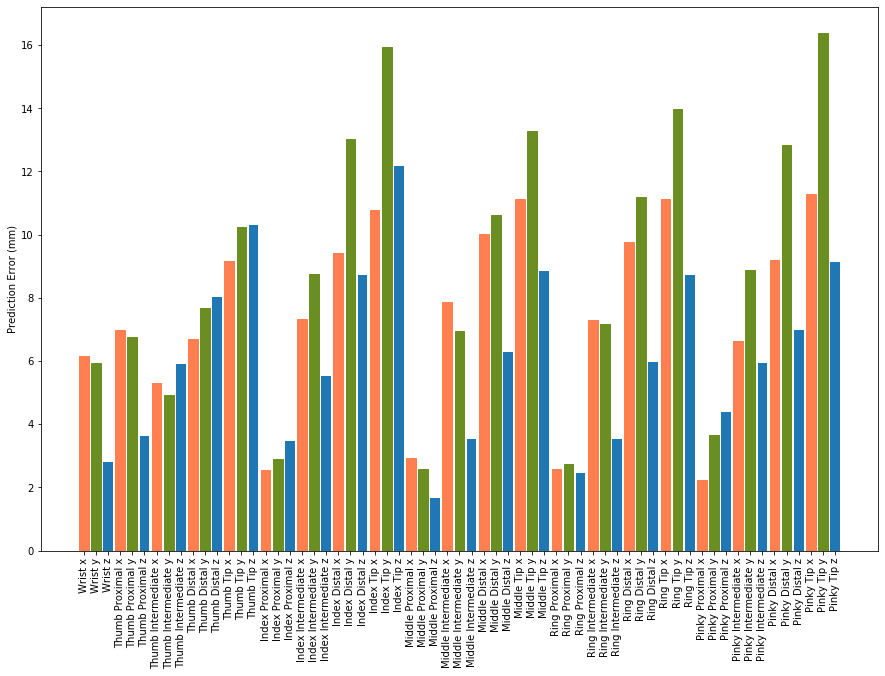

In [22]:
error = labels - preds
abs_error = np.absolute(error)
avg_error = np.mean(abs_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

In [24]:
def r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

In [25]:
r2_score(labels, preds)

0.9096615419579054

In [23]:
model_fc.save('FC_mega_dataset_all_joints_model.h5')